In [1]:
using Pkg
Pkg.activate("deconvolution"; shared=true)

"/Users/imolk/Library/Julia/environments/deconvolution/Project.toml"

In [2]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [3]:
using HypothesisTests
using Distributions
import StatsBase

In [4]:
using Revise
import DeconvolveDistribution
import DeconvolutionTests

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/DeconvolveDistribution/2elKn.ji for DeconvolveDistribution [ce248477-2e98-51a1-a641-d405f74c103f]
└ @ Base loading.jl:1185
┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/DeconvolutionTests/ze1Y1.ji for DeconvolutionTests [8d2f585b-c48a-511f-97ec-c3cd0c5244bb]
└ @ Base loading.jl:1185


In [5]:
function plot_pdf(d::DeconvolveDistribution.ExpoSpline; kwargs...)
    p = pdf(d)
    θ = d.domain
    Δ = median(diff(θ))
    plt.bar(θ, p./Δ, Δ; kwargs...)
end

plot_pdf (generic function with 1 method)

In [6]:
module KS
    using Distributions
    using DeconvolveDistribution
    using DeconvolveDistribution: DeconvolutionMethod
    using DeconvolutionTests
    include("../src/simulate.jl")

    function sim_deconv(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y, t::Function, method::DeconvolutionMethod; kwargs...)
        data = sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
        deconv_boot_test(data[:Xtilde], data[:Ytilde], data[:σ_X], data[:σ_Y], t, method; kwargs...)
    end
end

Main.KS

In [7]:
# using a module as a cheap way to encapsulate variables
import Random
Random.seed!(1)
sim_hetero = let 
    local F_X = MixtureModel([Normal(-2, 1), Normal(2, 1)], [0.4, 0.6])
    local F_Y = Normal(0, 2)
    local n_X = 200
    local n_Y = 120
    local σ_X_distr = Gamma(2.0, 1.0)
    local σ_Y_distr = Gamma(2.0, 2.0)
    KS.sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
end
;

In [8]:
efron = DeconvolveDistribution.EfronDeconv(6, range(-6.0, stop=6.0, length=32), 1.0);

In [9]:
@time d = DeconvolveDistribution.decon(
        efron, 
        cat(sim_hetero[:Xtilde], sim_hetero[:Ytilde]; dims=1),
        Normal.(0.0, cat(sim_hetero[:σ_X], sim_hetero[:σ_Y]; dims=1)),
        )
;

  7.655525 seconds (19.99 M allocations: 976.631 MiB, 7.19% gc time)


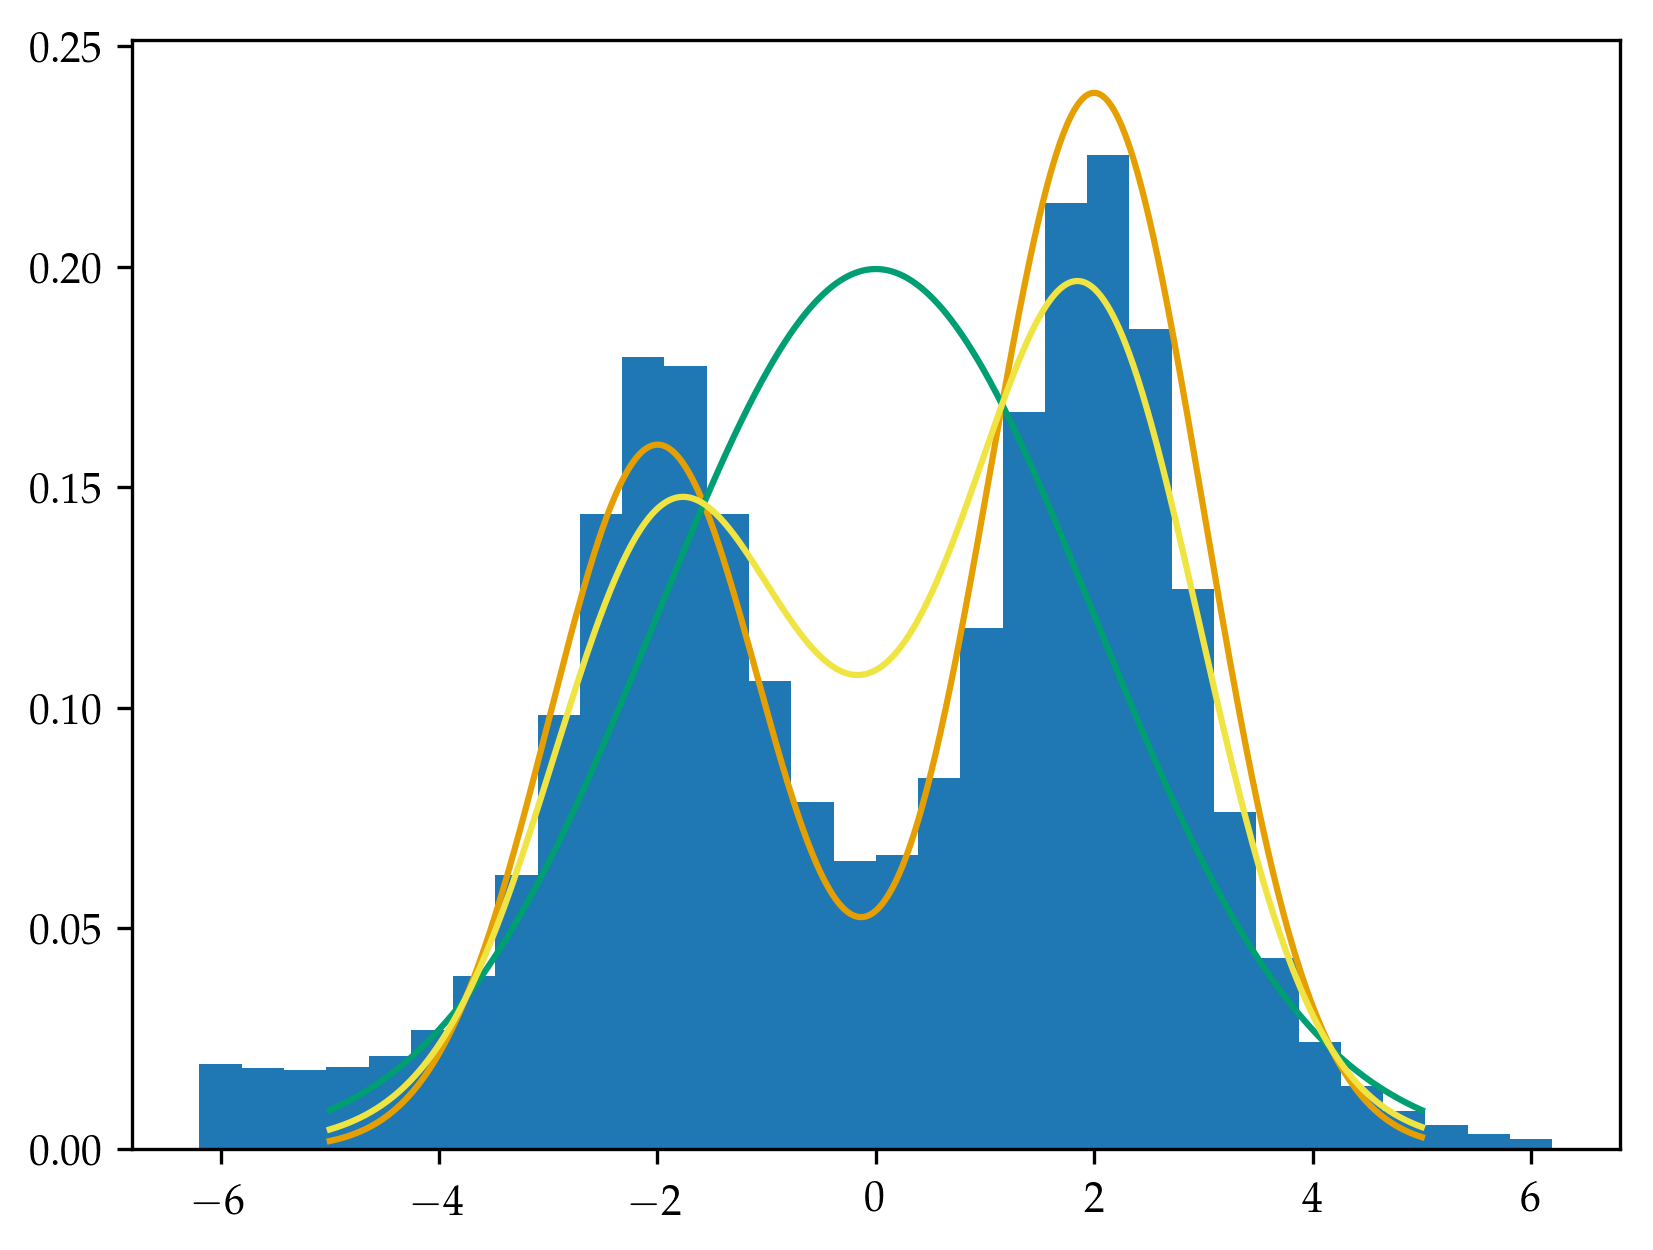

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x133943710>

In [10]:
plot_pdf(d)
xx = -5:0.01:5
plt.plot(xx, pdf.(sim_hetero[:F_X], xx), color=cbbPalette[1])
plt.plot(xx, pdf.(sim_hetero[:F_Y], xx), color=cbbPalette[3])
plt.plot(xx, 
    (   sim_hetero[:n_X].*pdf.(sim_hetero[:F_X], xx)
     .+ sim_hetero[:n_Y].*pdf.(sim_hetero[:F_Y], xx)
    ) / (sim_hetero[:n_X] + sim_hetero[:n_Y])
    , 
    color=cbbPalette[4])

In [11]:
DeconvolutionTests.deconv_boot_test(
    sim_hetero[:Xtilde],
    sim_hetero[:Ytilde],
    sim_hetero[:σ_X],
    sim_hetero[:σ_Y],
    DeconvolutionTests.KS_test_statistic,
    efron;
    niter=100
)
@time DeconvolutionTests.deconv_boot_test(
    sim_hetero[:Xtilde],
    sim_hetero[:Ytilde],
    sim_hetero[:σ_X],
    sim_hetero[:σ_Y],
    DeconvolutionTests.KS_test_statistic,
    efron;
    niter=100
)

  0.041122 seconds (17.79 k allocations: 46.100 MiB, 16.17% gc time)


0.47

In [12]:
n_X, n_Y = 200, 100

(200, 100)

In [13]:
KS.sim_deconv(
    Normal(0.0, 2.0), Normal(0.0, 2.0),
    Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
    n_X, n_Y, KS.KS_test_statistic,
    efron
    ; 
    niter=200
    ) 

0.755

# Distribution of p-values

## under the null: KS statistic

In [19]:
function plot_pvals(pvals)
    bins = 0:0.05:1.0
    # weights add up to one
    # (don't integrate to one)
    weights = fill(1/length(pvals), length(pvals))
    plt.plt[:hist](pvals, 
        bins=bins, 
        weights=weights,
        color=cbbPalette[2], 
        edgecolor="white")
    plt.axhline(1/length(bins), color=cbbPalette[6])
    plt.xlabel("p-value")
    plt.ylabel("frequency")
    plt.xlim(0, 1)
end

plot_pvals (generic function with 1 method)

In [14]:
@time null_pvals_KS = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(0.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic,
        efron
        ; 
        niter=200
        ) 
    for _ in 1:400]
;

 19.147193 seconds (14.77 M allocations: 20.276 GiB, 12.03% gc time)


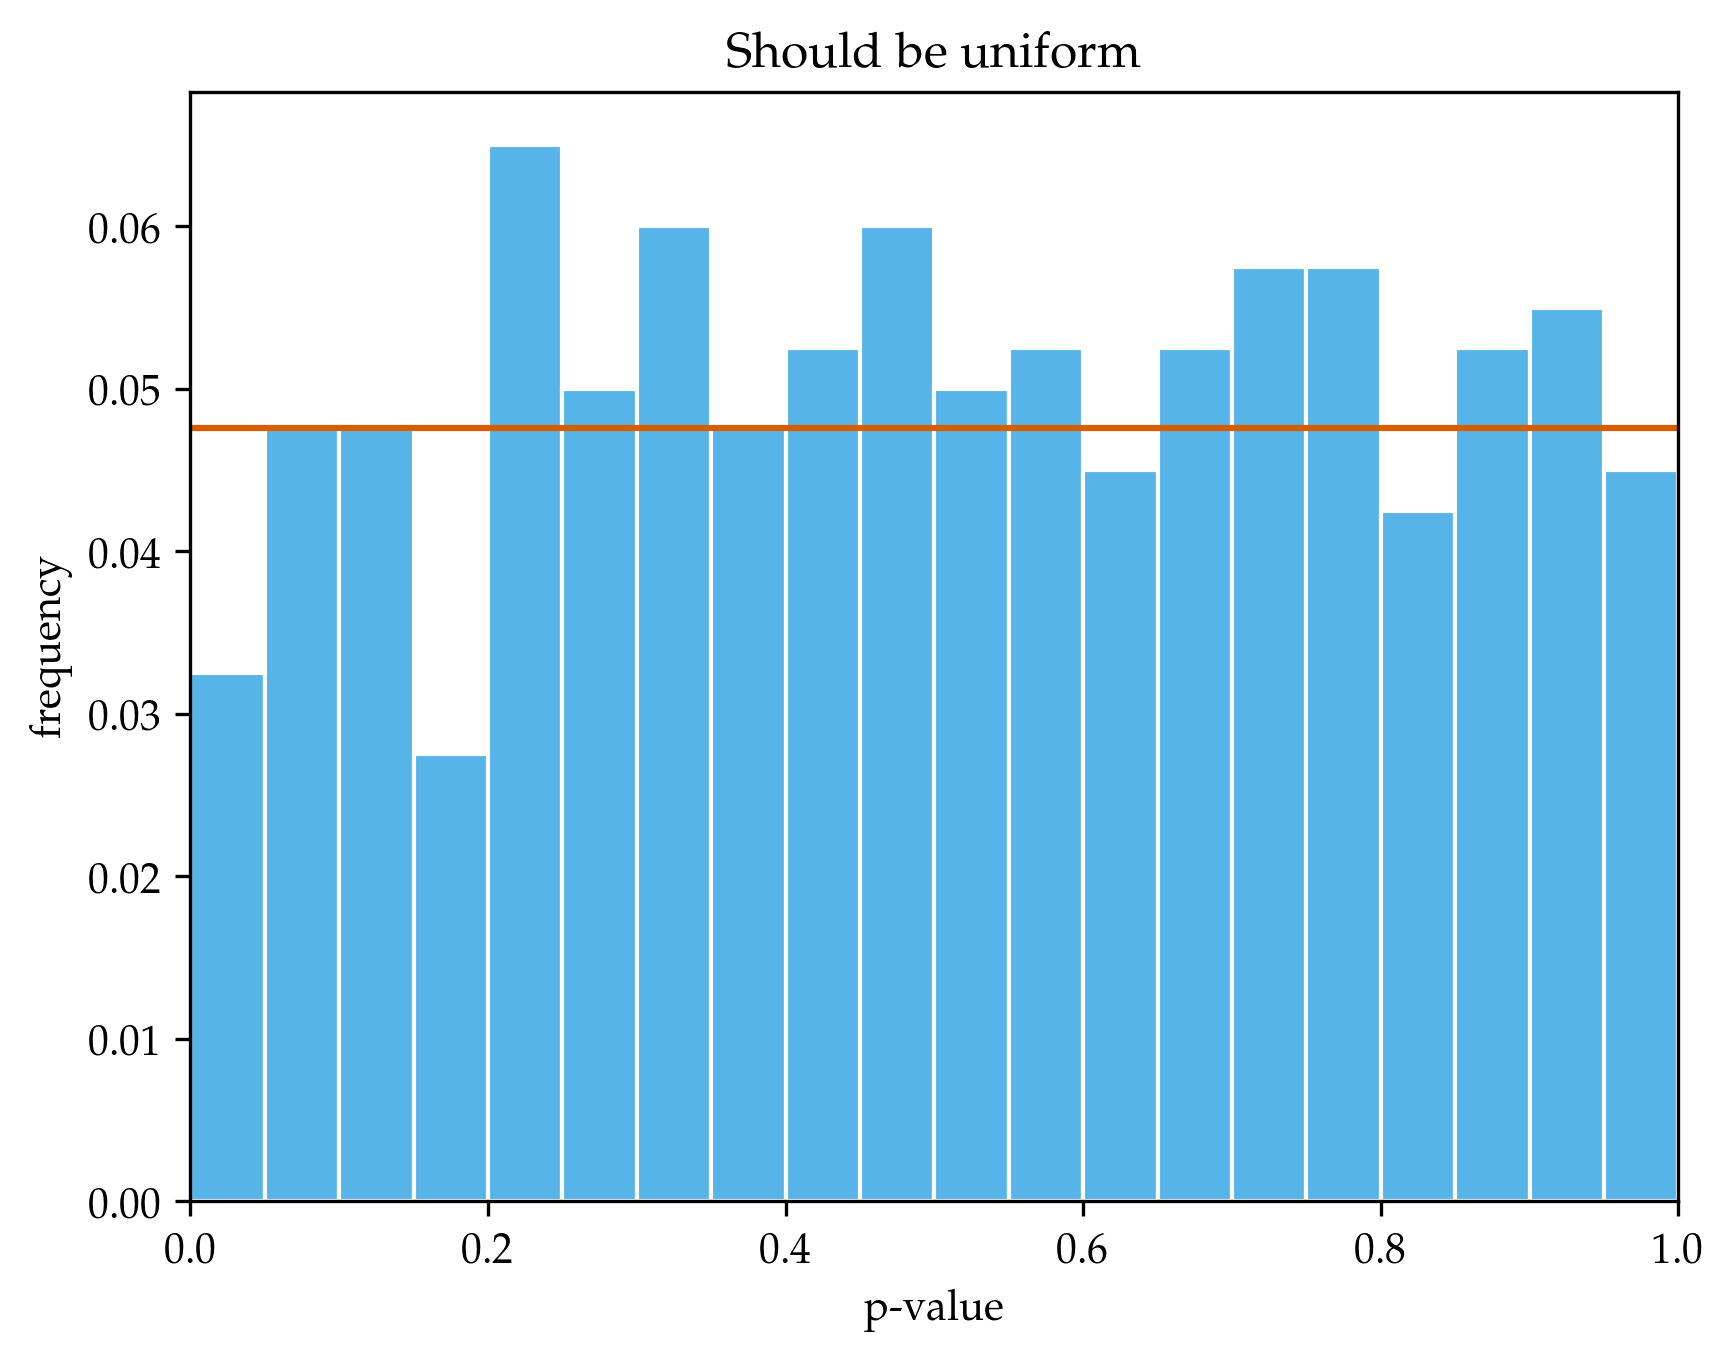

In [24]:
plot_pvals(null_pvals_KS)
plt.title("Should be uniform")
;

## Under the alternative: KS

In [16]:
@time alt_pvals_KS = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(1.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic,
        efron
        ; 
        niter=400
        ) 
    for _ in 1:400]
;

 24.210301 seconds (16.47 M allocations: 24.135 GiB, 12.50% gc time)


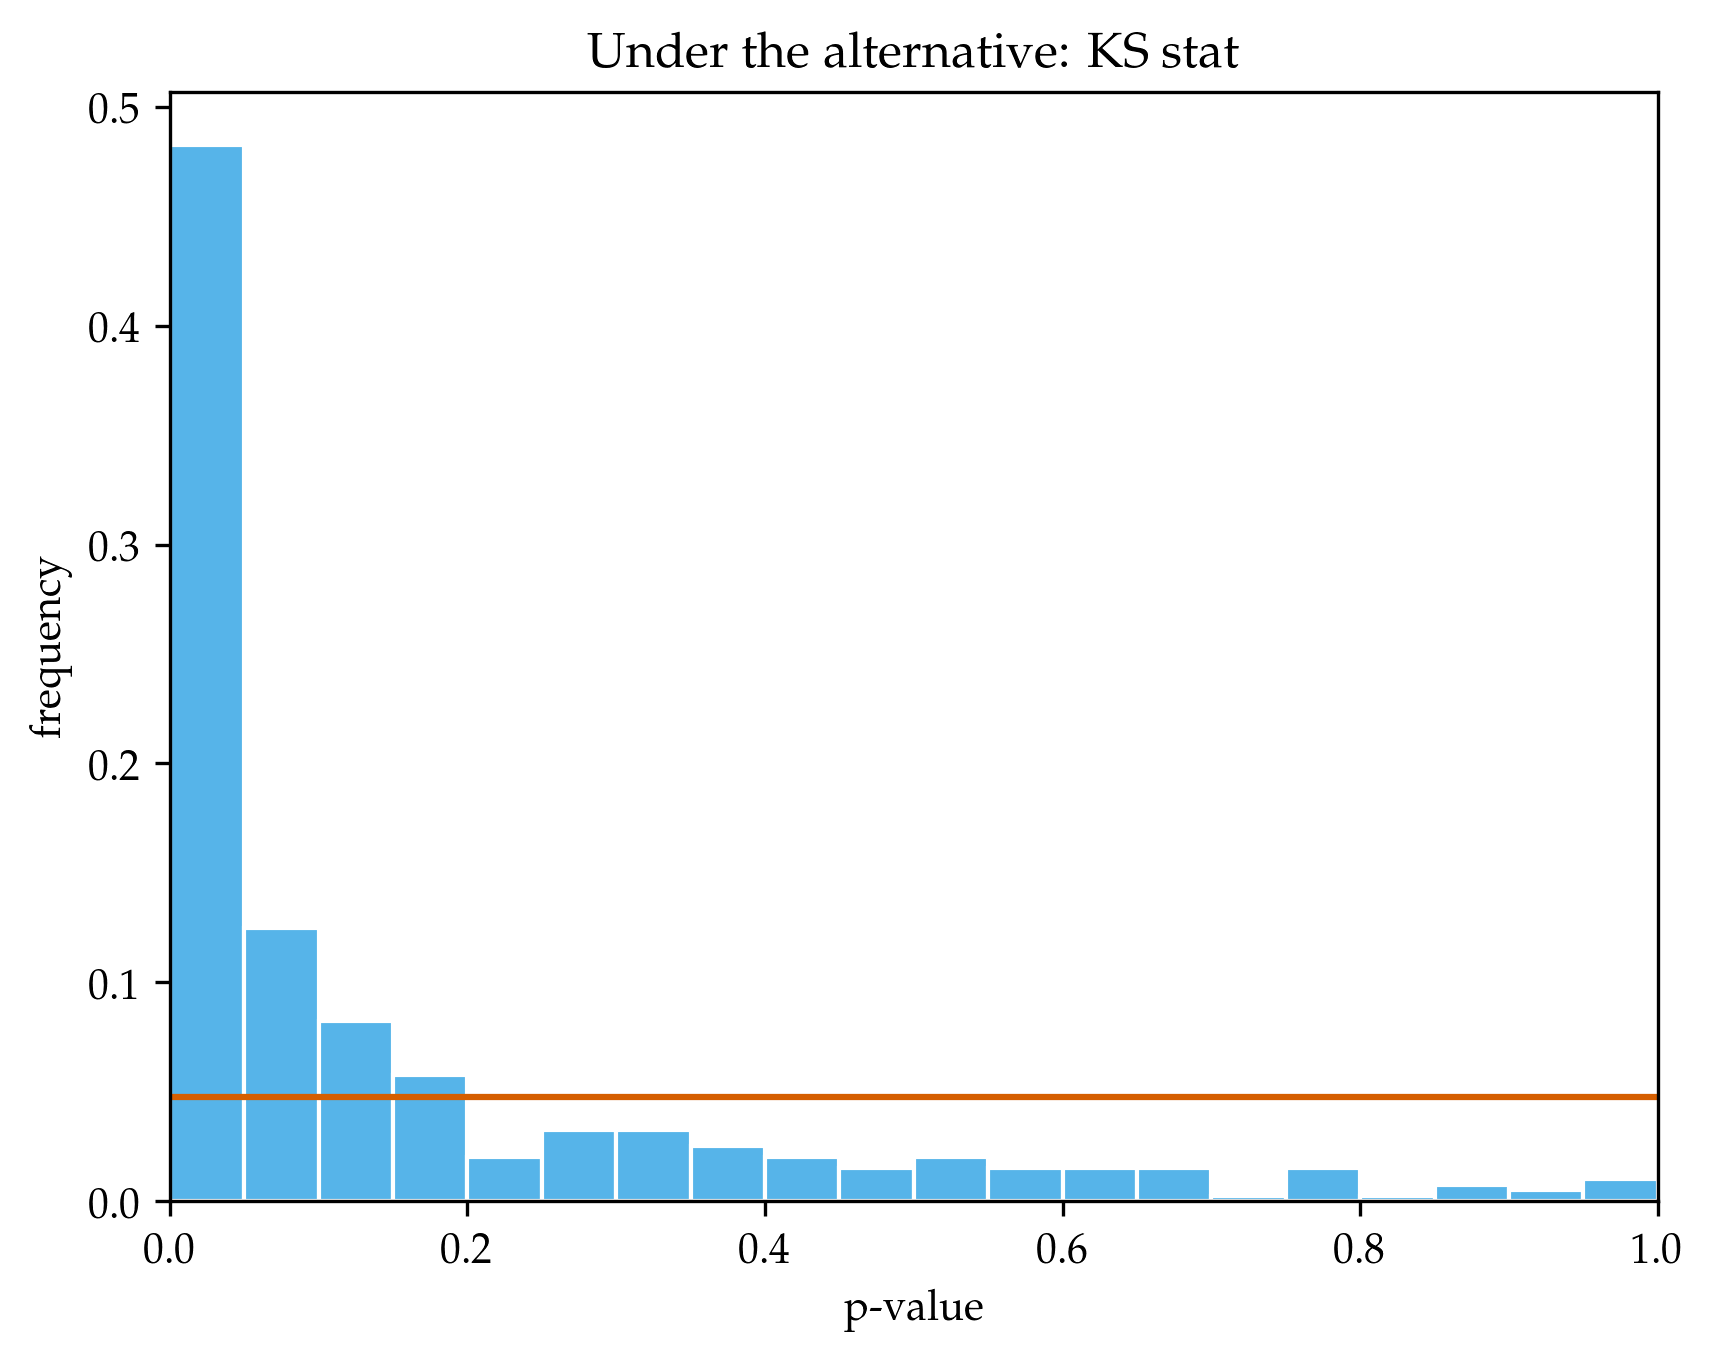

In [25]:
plot_pvals(alt_pvals_KS)
plt.title("Under the alternative: KS stat")
;

## under the null: deconvolved KS

In [18]:
@time null_pvals_KSdecon = let
    n_X = 100
    n_Y = 150
    p = Inf
    efron_sub = DeconvolveDistribution.EfronDeconv(5, range(-6.0, stop=6.0, length=32), 1.0);
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, efron_sub, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(0.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp,
            efron
            ; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

┌ Warning: Deprecated syntax `implicit assignment to global variable `n_X``.
│ Use `global n_X` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `n_Y``.
│ Use `global n_Y` instead.
└ @ nothing none:0
┌ Warning: `linspace(start, stop, length::Integer)` is deprecated, use `range(start, stop=stop, length=length)` instead.
│   caller = top-level scope at In[18]:6
└ @ Core In[18]:6
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47


670.797219 seconds (833.61 M allocations: 506.646 GiB, 10.87% gc time)


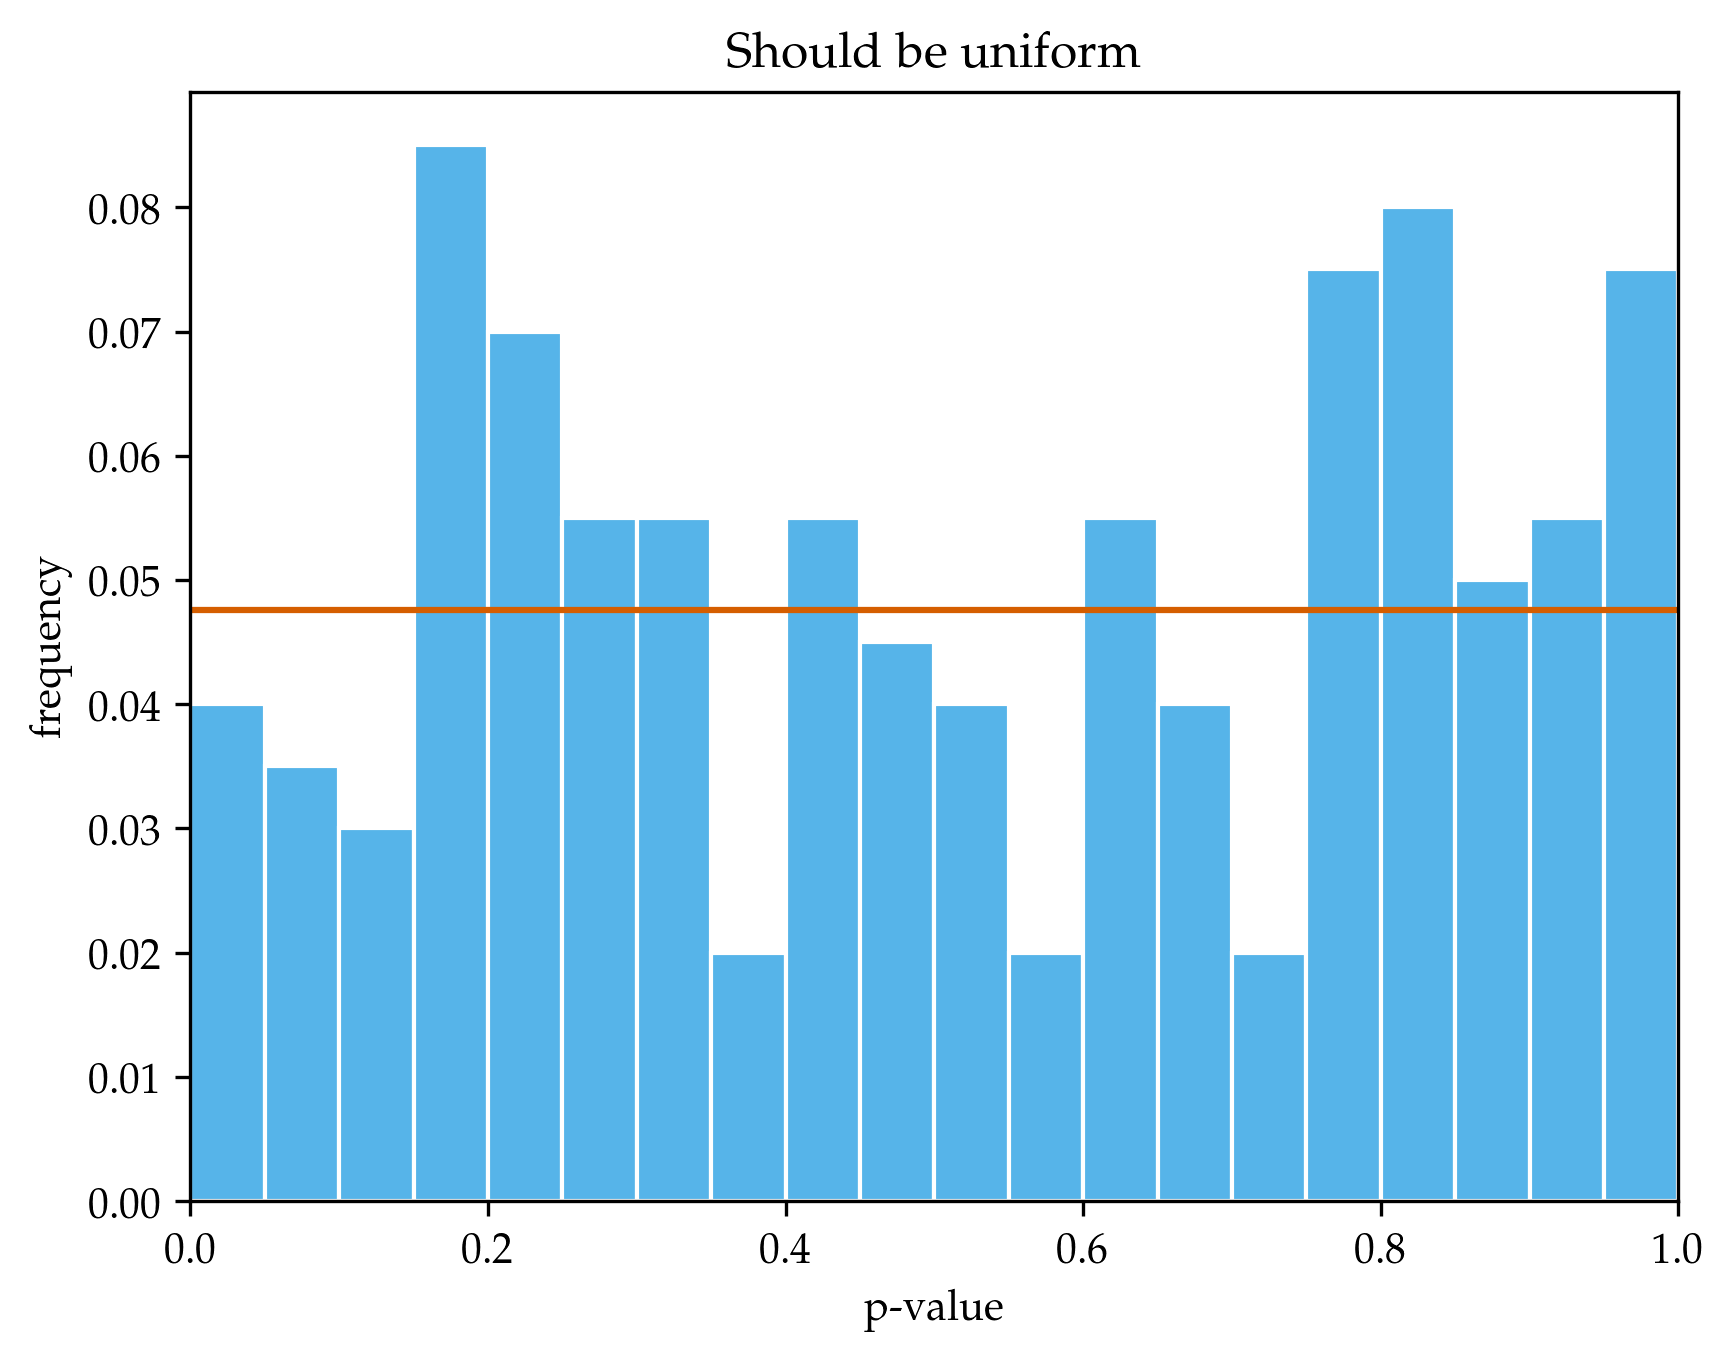

In [20]:
plot_pvals(null_pvals_KSdecon)
plt.title("Should be uniform")
;

## under the alternative: deconvolved KS

In [21]:
n_X, n_Y = 200, 100

(200, 100)

In [22]:
@time alt_pvals_KSdecon = let
    p = Inf
    efron_sub = DeconvolveDistribution.EfronDeconv(5, range(-6.0, stop=6.0, length=32), 1.0);
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, efron_sub, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(1.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp,
            efron
            ; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

┌ Warning: `linspace(start, stop, length::Integer)` is deprecated, use `range(start, stop=stop, length=length)` instead.
│   caller = top-level scope at In[22]:4
└ @ Core In[22]:4
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 1.1304738511654455e-16 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum i

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

716.782045 seconds (843.17 M allocations: 570.860 GiB, 11.39% gc time)


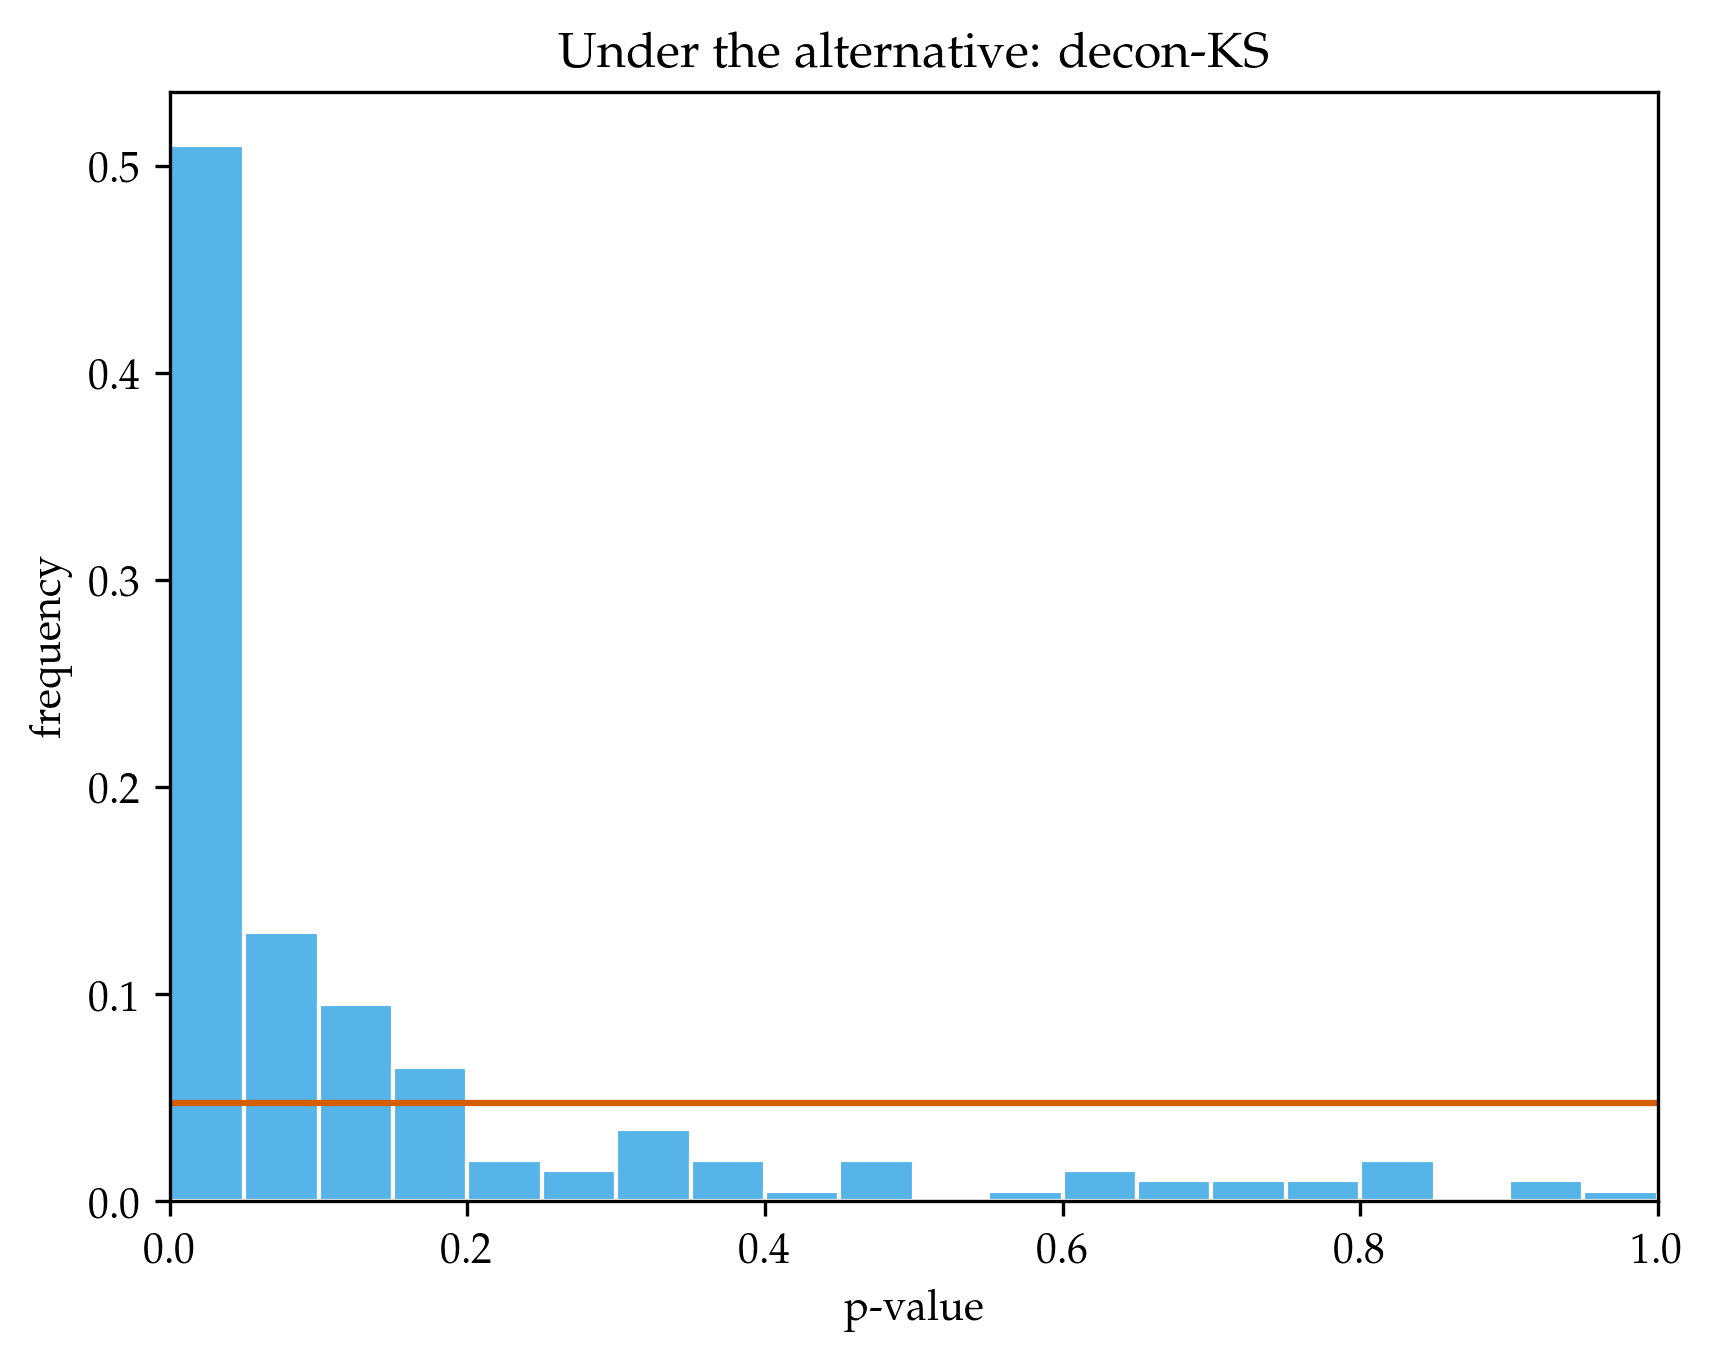

In [23]:
plot_pvals(alt_pvals_KSdecon)
plt.title("Under the alternative: decon-KS")
;